In [1]:
import pandas as pd
from backend.src.utils.logging_handler import setup_logging
from backend.src.utils.config import Config

config = Config("../config.yaml")
setup_logging()

feature_engineering_config = config.get("feature_engineering")
preprocessor_config = config.get("preprocess")
model_config = config.get("model")

target_feature = preprocessor_config.get("target")
trend_length = preprocessor_config.get("trend_length")
window_size = preprocessor_config.get("window_size")
epochs: int = model_config.get("epochs")
batch_size: int = model_config.get("batch_size")

interval: str = feature_engineering_config.get("time_series_interval")

training_file_path: str = f"../data/twelvedata/time series ({interval})/AAPL_time_series.csv"
validation_file_path: str = f"../data/twelvedata/time series ({interval})/ABBV_time_series.csv"

scaler_path: str = "C:/Users/mohae/Desktop/StockTrendPredictor/backend/src/models/saved scalers/scaler.save"

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)


In [2]:
from backend.src.pipelines.stock_trend_lstm_train_pipeline import StockTrendLSTMTrainPipeline
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

training_pipeline = StockTrendLSTMTrainPipeline(
    training_time_series=training_df,
    validation_time_series=validation_df,
    target_feature=target_feature,
    trend_length=trend_length,
    window_size=window_size,
    epochs=epochs,
    batch_size=batch_size,
    scaler_save_path=scaler_path,
)
training_pipeline.prepare_data()

2026-01-05 00:36:02,871 | WARNING | tensorflow | From C:\Users\mohae\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

2026-01-05 00:36:04,162 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | StockTrendLSTMPipeline initialized
2026-01-05 00:36:04,162 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | Starting data preparation
2026-01-05 00:36:04,209 | INFO | backend.src.preprocessing.time_series_preprocessor | Preprocessing summary | input rows: 12223 | output rows: 12223 | dropped: 0 (100.00% retained)
2026-01-05 00:36:04,224 | INFO | backend.src.preprocessing.time_series_preprocessor | Preprocessing summary | input rows: 5000 | output rows: 5000 | dropped: 0 (100.00% retained)
2026-01-05 00:36:04,759 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | X_train shape: (12123, 30, 30)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
training_pipeline.labeled_training_ts.head(10)


,open,high,low,close,volume,ADX,ATR,%Bollinger,EMA,MACD,RSI,sma,EMA dist. (%),EMA distance change,EMA dist. norm. (ATR),EMA slope (%),EMA acc.,EMA distance std.,log return(1),log return(2),log return(3),log return(9),close > EMA,EMA slope pos.,log return pos.,ATR stretch,bb% > 1,bb% < 0,day_of_week,hour_of_day,label
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-14 14:00:00,37.48,37.53,37.44,37.49,9953656,26.90,0.27,0.15,37.64,-0.08,40.69,37.67,-0.0040,0.0013,-0.5556,-0.0011,0.01,0.0044,0.000267,-0.000533,0.000000,-0.012459,0,0,1,0,0,0,0,14,0
2019-01-14 15:00:00,37.49,37.50,37.37,37.50,16455388,26.58,0.26,0.19,37.61,-0.10,41.05,37.61,-0.0029,0.0011,-0.4231,-0.0008,0.01,0.0035,0.000267,0.000533,-0.000267,-0.012982,0,0,1,0,0,0,0,15,1
2019-01-15 09:00:00,37.57,38.15,37.51,37.88,27153228,25.87,0.29,0.48,37.67,-0.07,52.93,37.60,0.0056,0.0085,0.7241,0.0016,0.09,0.0045,0.010082,0.010349,0.010616,-0.003952,1,1,1,0,0,0,1,9,1
2019-01-15 10:00:00,37.90,38.02,37.83,37.92,11783852,25.21,0.28,0.52,37.72,-0.05,53.98,37.58,0.0053,-0.0003,0.7143,0.0013,-0.01,0.0052,0.001055,0.011138,0.011404,-0.004211,1,1,1,0,0,0,1,10,1
2019-01-15 11:00:00,37.93,38.22,37.92,38.12,23549480,25.21,0.29,0.68,37.80,-0.02,58.92,37.64,0.0085,0.0032,1.1034,0.0021,0.03,0.0061,0.005260,0.006316,0.016398,0.015066,1,1,1,1,0,0,1,11,1
2019-01-15 12:00:00,38.12,38.25,38.10,38.19,8979736,25.29,0.28,0.74,37.88,0.02,60.52,37.73,0.0082,-0.0003,1.1071,0.0021,0.00,0.0067,0.001835,0.007095,0.008150,0.021170,1,1,1,1,0,0,1,12,1
2019-01-15 13:00:00,38.19,38.35,38.09,38.09,12214996,25.66,0.27,0.69,37.92,0.03,57.10,37.80,0.0045,-0.0037,0.6296,0.0011,-0.04,0.0069,-0.002622,-0.000787,0.004473,0.015878,1,1,0,0,0,0,1,13,1
2019-01-15 14:00:00,38.09,38.30,37.96,38.24,11316036,25.34,0.28,0.84,37.98,0.06,60.68,37.88,0.0068,0.0023,0.9286,0.0016,0.02,0.0073,0.003930,0.001308,0.003143,0.019275,1,1,1,0,0,0,1,14,1
2019-01-15 15:00:00,38.24,38.34,38.18,38.26,10978704,25.16,0.27,0.84,38.04,0.08,61.15,37.97,0.0058,-0.0010,0.8148,0.0016,0.00,0.0075,0.000523,0.004453,0.001831,0.020598,1,1,1,0,0,0,1,15,1


In [4]:
training_pipeline.build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            16200     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 36451 (142.39 KB)
Trainable params: 36451 (142.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2026-01-05 00:36:05,631 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | Model built successfully


2026-01-05 00:36:05,677 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | Starting model training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

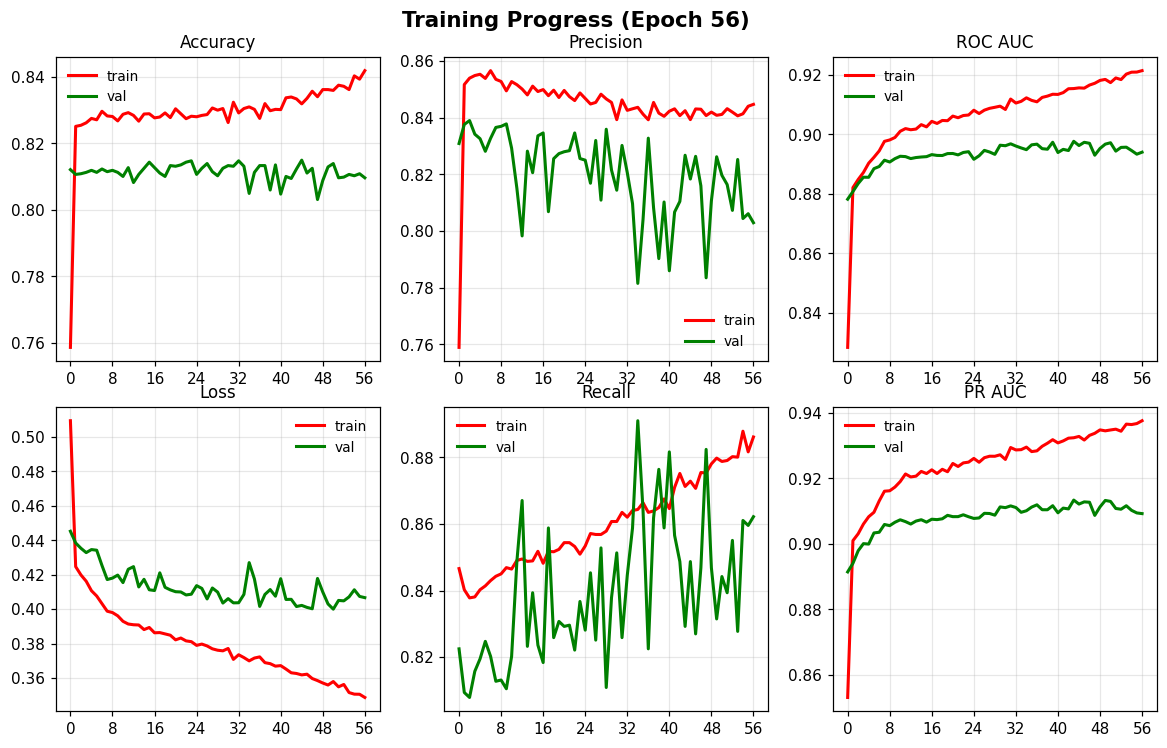

2026-01-05 00:41:42,456 | INFO | backend.src.models.stock_trend_lstm.stock_trend_lstm_model | Model saved to:C:/Users/mohae/Desktop/StockTrendPredictor/backend/src/models/saved models/trained_StockTrendLSTM_model.keras
2026-01-05 00:41:42,457 | INFO | backend.src.pipelines.stock_trend_lstm_train_pipeline | Training completed


In [5]:
%matplotlib inline
history = training_pipeline.train()